# ML Using LightGBM

## Load in libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import pickle
import re

In [2]:
NY = pd.read_parquet('../data/ML_Data/NY', engine='pyarrow')
TX = pd.read_parquet('../data/ML_Data/TX', engine='pyarrow')
FL = pd.read_parquet('../data/ML_Data/FL', engine='pyarrow')
CA = pd.read_parquet('../data/ML_Data/CA', engine='pyarrow')

## Visualize Cross validation with SKlearn [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
Since our data is a timer series we can't randomly split. To use cross validation we will test on different time periods.

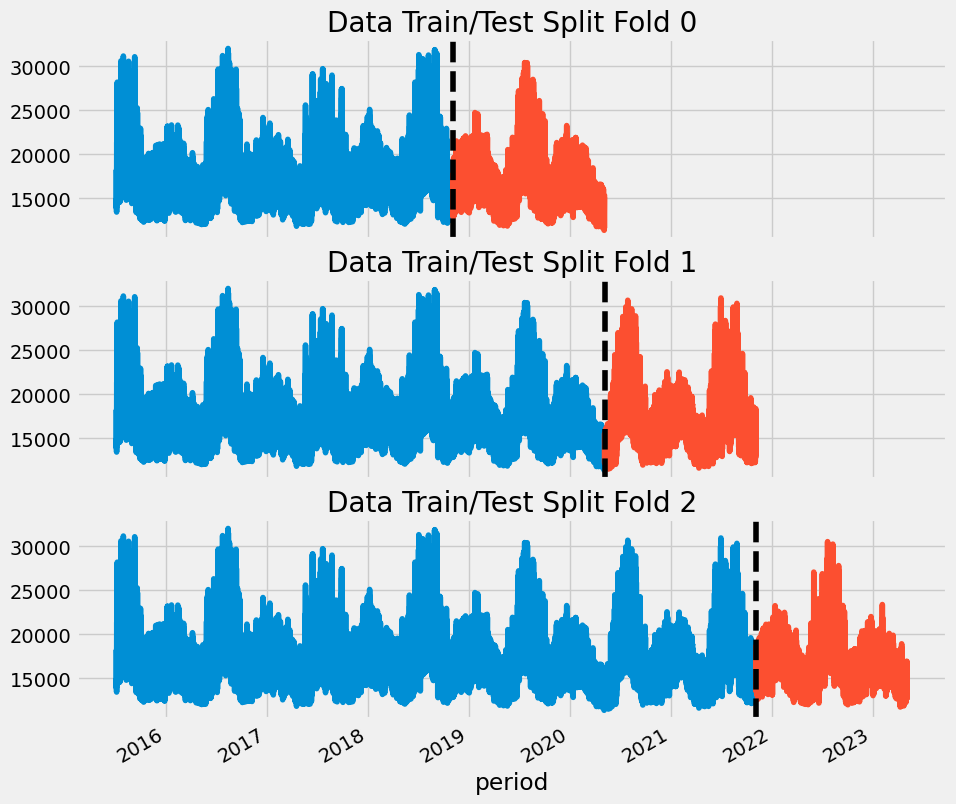

In [3]:
fig, axs = plt.subplots(3,1, figsize=(10,10), sharex=True)
tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
fold = 0
for train_idx, val_idx in tss.split(NY):
    train = NY.iloc[train_idx]
    test = NY.iloc[val_idx]
    train['value'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['value'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [4]:
TARGET = 'value'
FEATURES = NY.columns[2:]
FEATURES = sorted(FEATURES)

In [5]:
TX_params1 = {
    "n_jobs": -1,
    "boosting": "gbrt",
    "num_iterations": 10000,
    "early_stopping_round": 100,
    "max_depth": 10,
    "learning_rate": 0.005,
    "num_leaves": 30,
    "lambda_l1": 30,
    "lambda_l2": 0,
    "seed": 0,
    "metric": ['rmse','mae'],
    "device_type": 'gpu',
    "min_data_in_leaf": 12,
    "bagging_fraction": .8,
    "cat_smooth": 18,
    'max_bin': 80,
    "bagging_freq": 8,
    "min_sum_hessian_in_leaf" :250,
    'path_smooth':22,
    "feature_fraction": .6,
    "importance_type" :'split',
    "extra_trees":  False,
    'force_col_wise': True

}

## Traing our model with [LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#)
Since we have to train 4 model we create a function that will take in a dataframe as a parameter. The optional parameters
are params which is a dictionary of parameters to pass to the model. week_list will be used to graph a specfic week of data.
show_graph will defaults to 'no' if yes then the function will plot.
1. the actual vs prediction
2. feature importance
3. a week of data.

The week of data zooms in on our actual and predicted helping us better visualize how the model is performing.

For each cross validation we will store the scores in a list. We have 2 list because we are using rsme and mae
to score our model.

In [6]:
def lgbm_train(df, params=None, week_list=None, show_graph = "no"):
    if params is None:
        params = {}
    tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
    df = df.sort_index()
    fold = 0
    preds = []
    scores_rmse = []
    scores_mae = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_test = test[FEATURES]
        y_test = test[TARGET]
        reg = LGBMRegressor()
        reg.set_params(**params)
        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0,)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores_rmse.append(score_rmse)
        scores_mae.append(mean_absolute_error(y_test,y_pred))
    print(f'Score across folds {np.mean(scores_rmse):0.4f}')
    print(f'Fold scores:{scores_rmse}')
    print(f'Score across folds {np.mean(scores_mae):0.4f}')
    print(f'Fold scores:{scores_mae}')

    if show_graph.lower() == 'yes':
        if week_list is None:
            week = ['03-20-2022', '03-27-2022']
        else:
            week = week_list
        test['prediction'] = reg.predict(X_test)
        df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
        ax = df[['value']].plot(figsize=(15, 6))
        df['prediction'].plot(ax=ax, style='.')
        plt.legend(['Actual', 'Predicted'],loc='upper right')
        ax.set_title('Actual VS. Predicted')
        plt.show()

        ax = df.loc[(df.index > week[0]) & (df.index < week[1])]['value'] \
        .plot(figsize=(15, 6), title='Week Of Data')
        df.loc[(df.index > week[0]) & (df.index < week[1])]['prediction'] \
            .plot()
        plt.legend(['Actual','Predicted'],loc='upper right')
        plt.show()

        fig, ax = plt.subplots(figsize=(10,10))
        fi = pd.DataFrame(data=reg.feature_importances_,
            index = reg.feature_name_,
            columns=['importance'])
        fi.sort_values('importance', ascending=False)[:15].plot(kind='barh', ax=ax)

    return reg, df

[LightGBM] [Warning] boosting is set=gbrt, boosting_type=gbdt will be ignored. Current value: boosting=gbrt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=250, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=250
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbrt, boosting_type=gbdt will be ignored. C

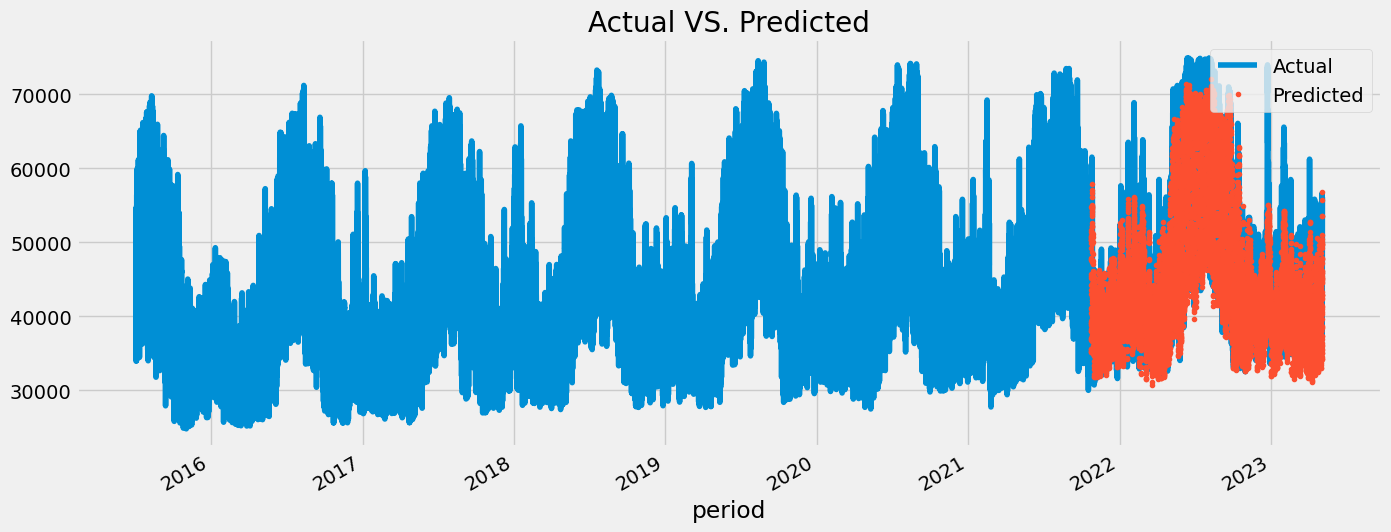

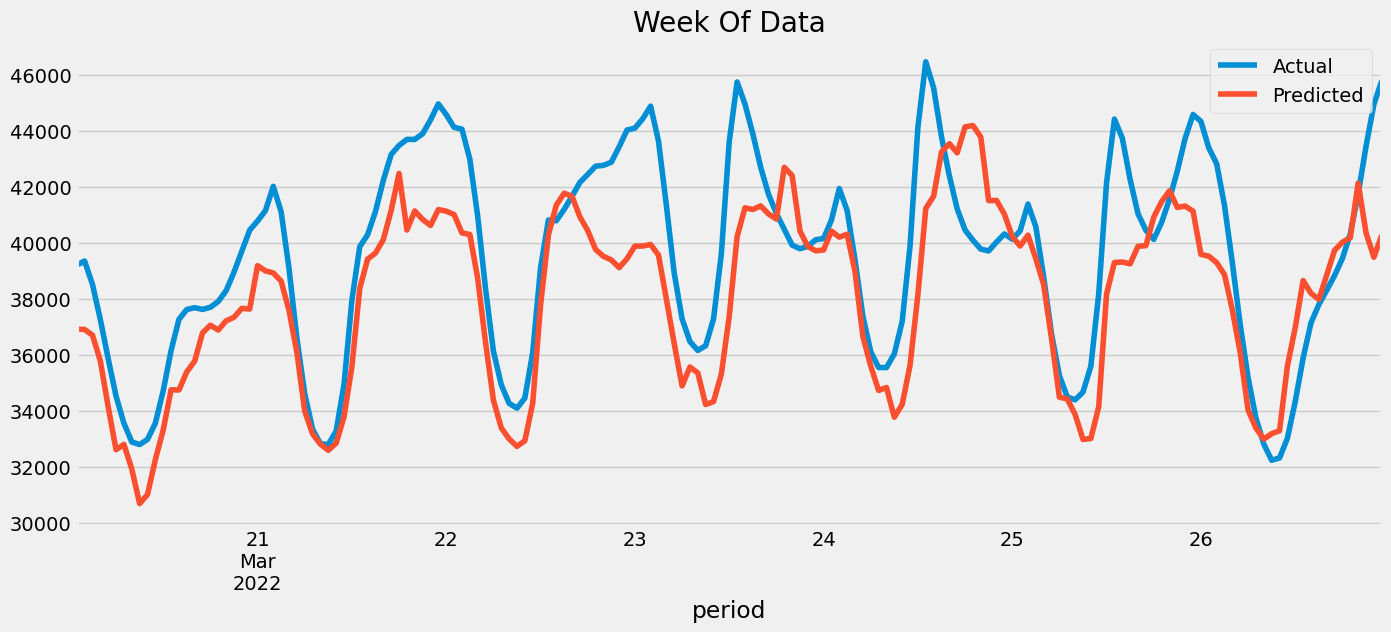

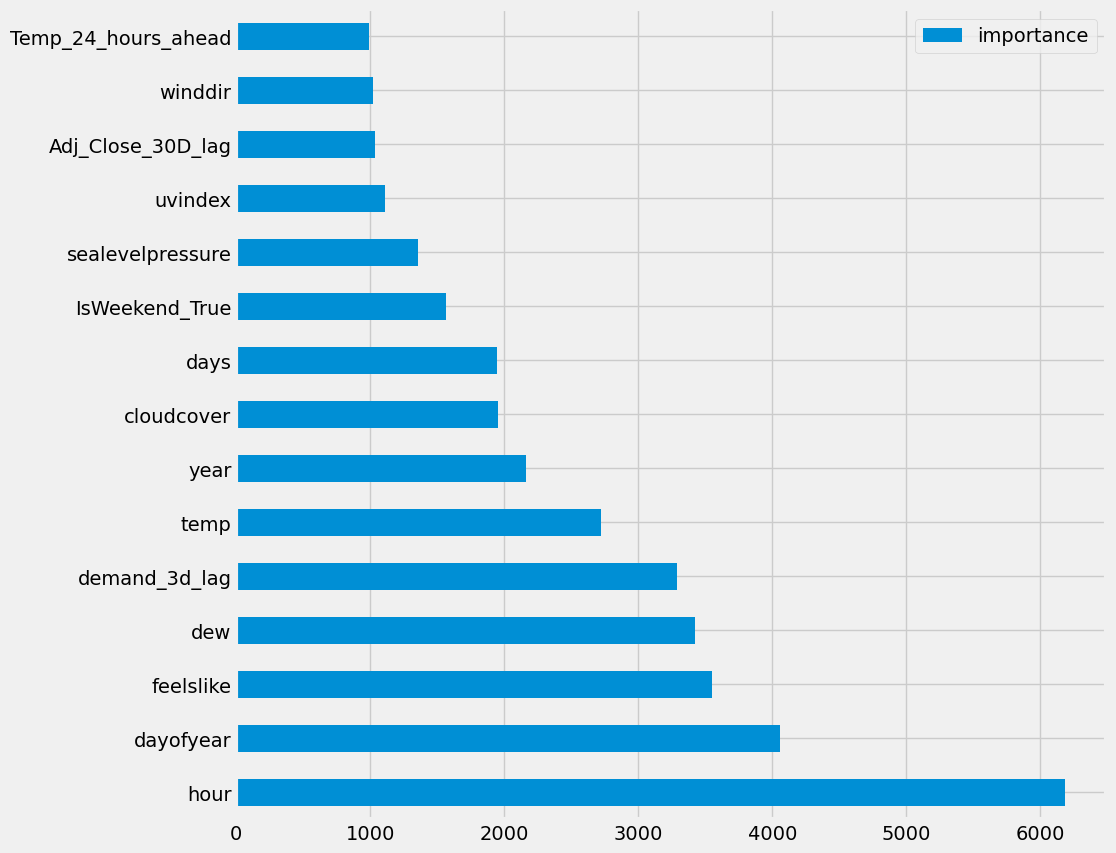

In [7]:
model_TX, Texas_df =lgbm_train(TX, TX_params1, show_graph ='yes')

[LightGBM] [Warning] boosting is set=gbrt, boosting_type=gbdt will be ignored. Current value: boosting=gbrt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=250, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=250
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbrt, boosting_type=gbdt will be ignored. C

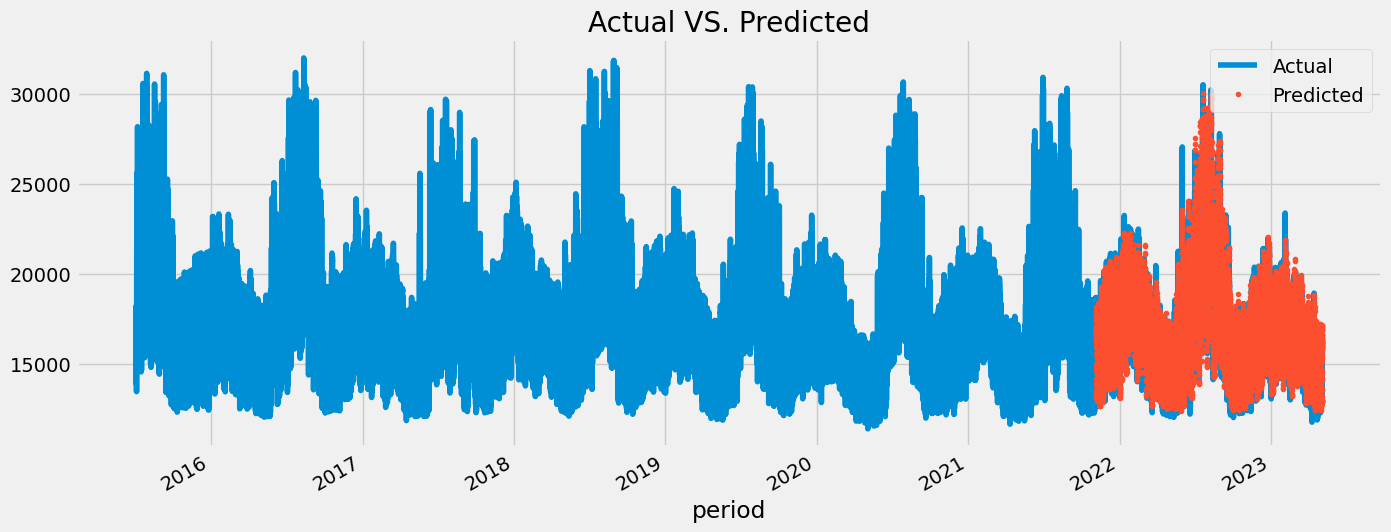

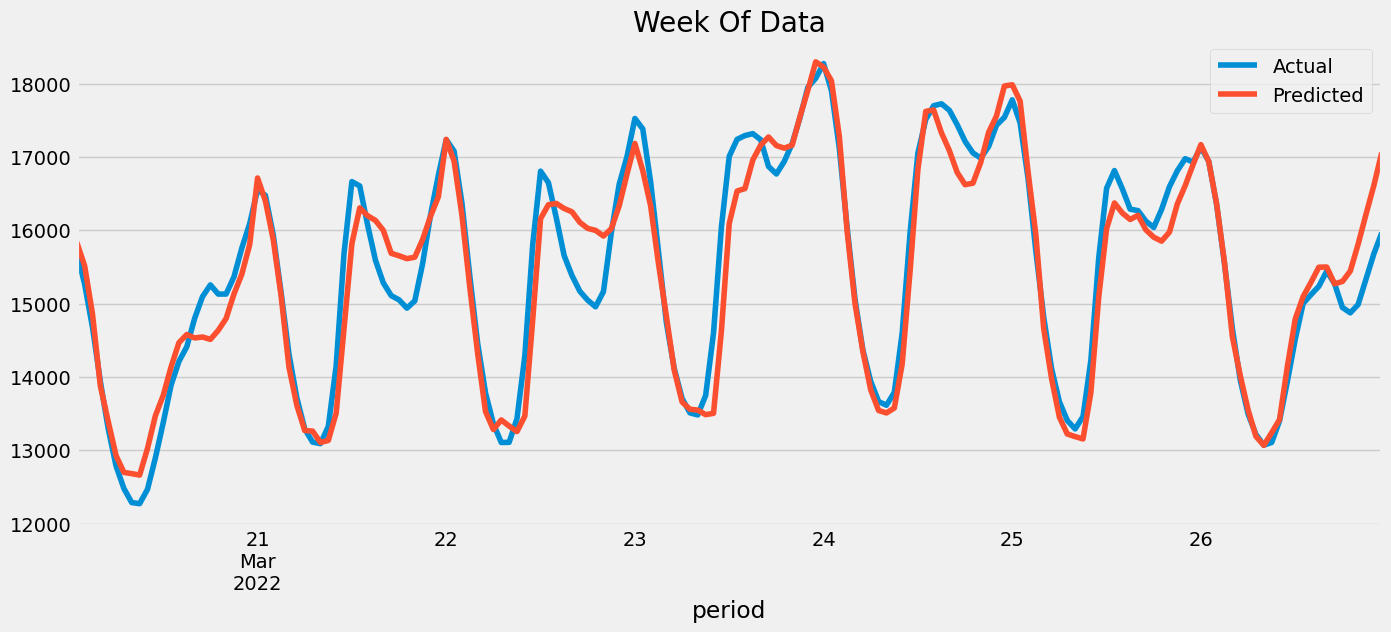

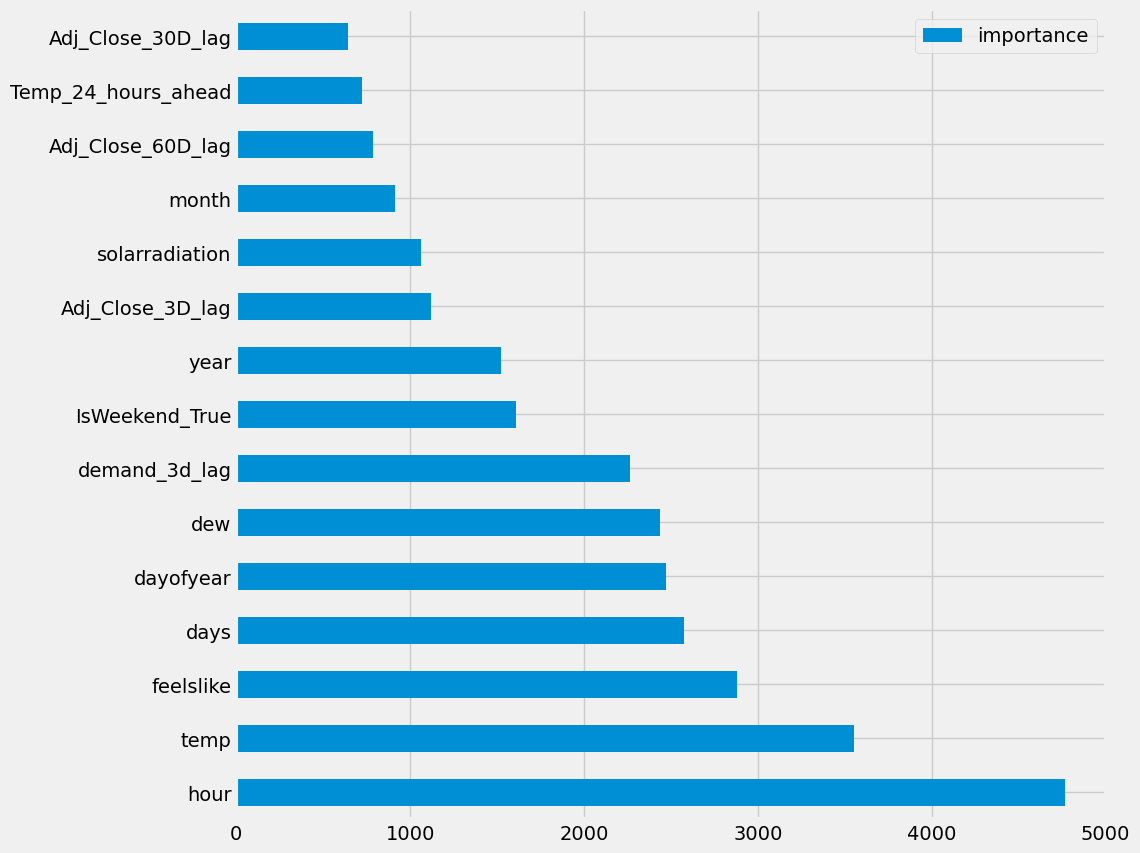

In [8]:
model_NY, NY_df = lgbm_train(NY, TX_params1, show_graph='yes')

[LightGBM] [Warning] boosting is set=gbrt, boosting_type=gbdt will be ignored. Current value: boosting=gbrt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=250, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=250
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbrt, boosting_type=gbdt will be ignored. C

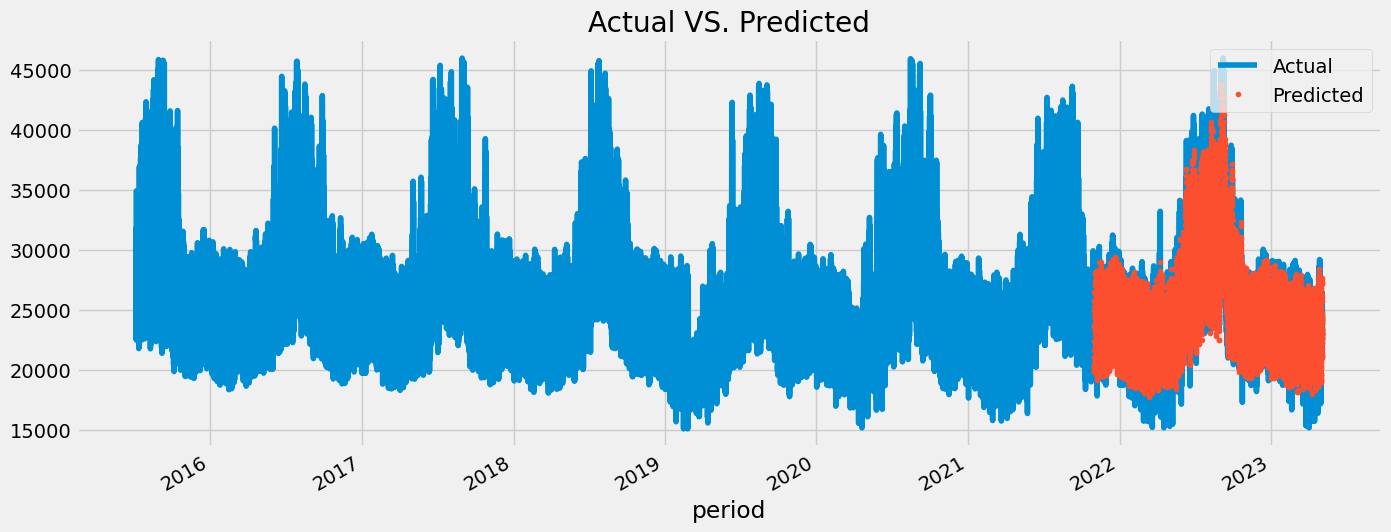

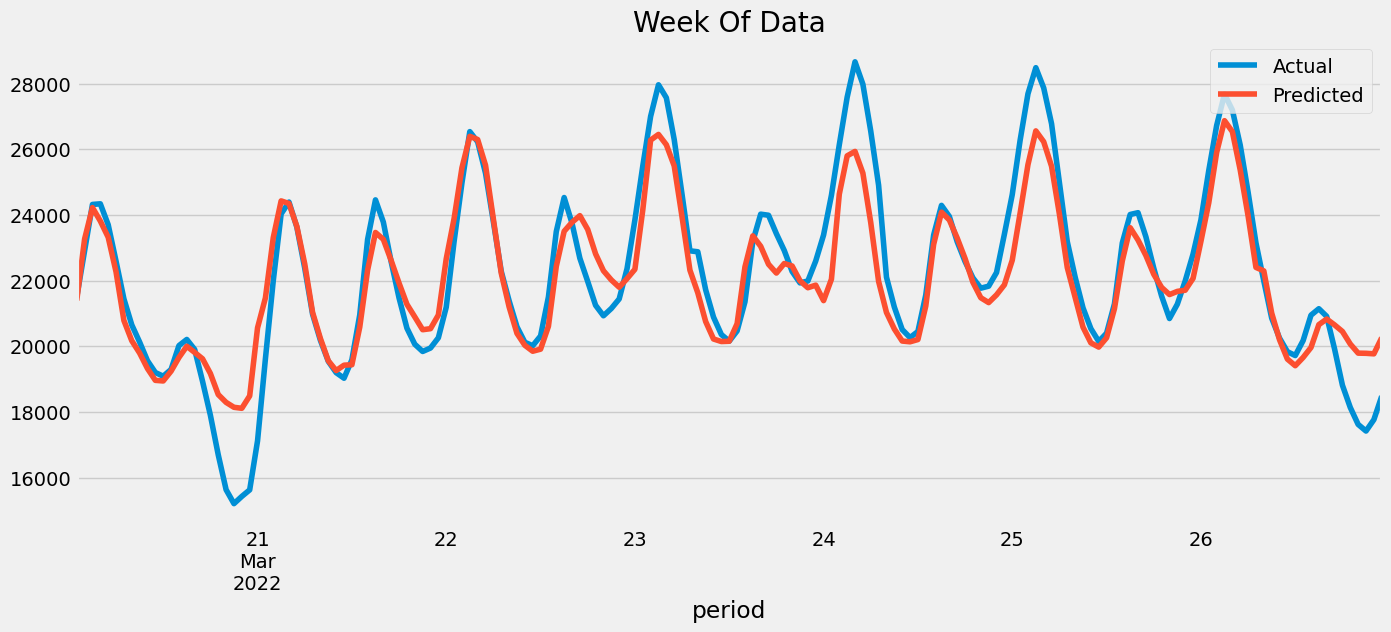

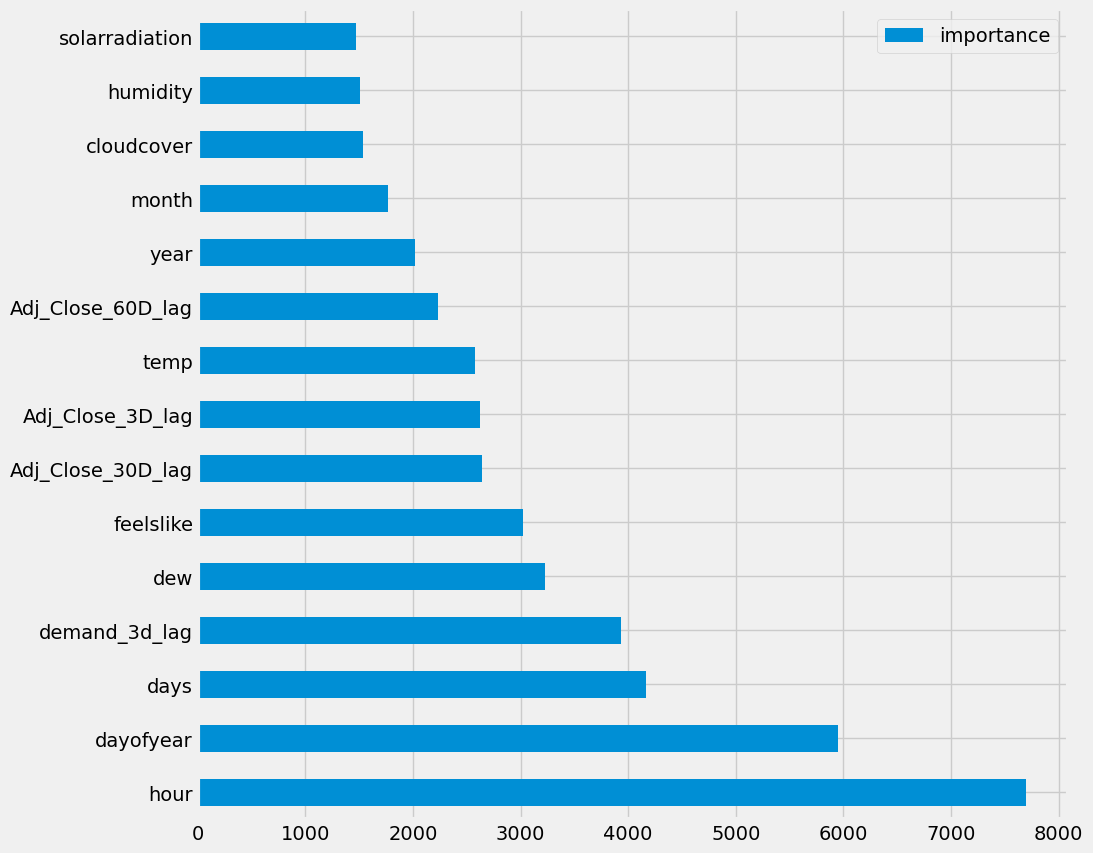

In [9]:
model_CA, CA_df =lgbm_train(CA, TX_params1, show_graph='yes')

[LightGBM] [Warning] boosting is set=gbrt, boosting_type=gbdt will be ignored. Current value: boosting=gbrt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=250, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=250
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbrt, boosting_type=gbdt will be ignored. C

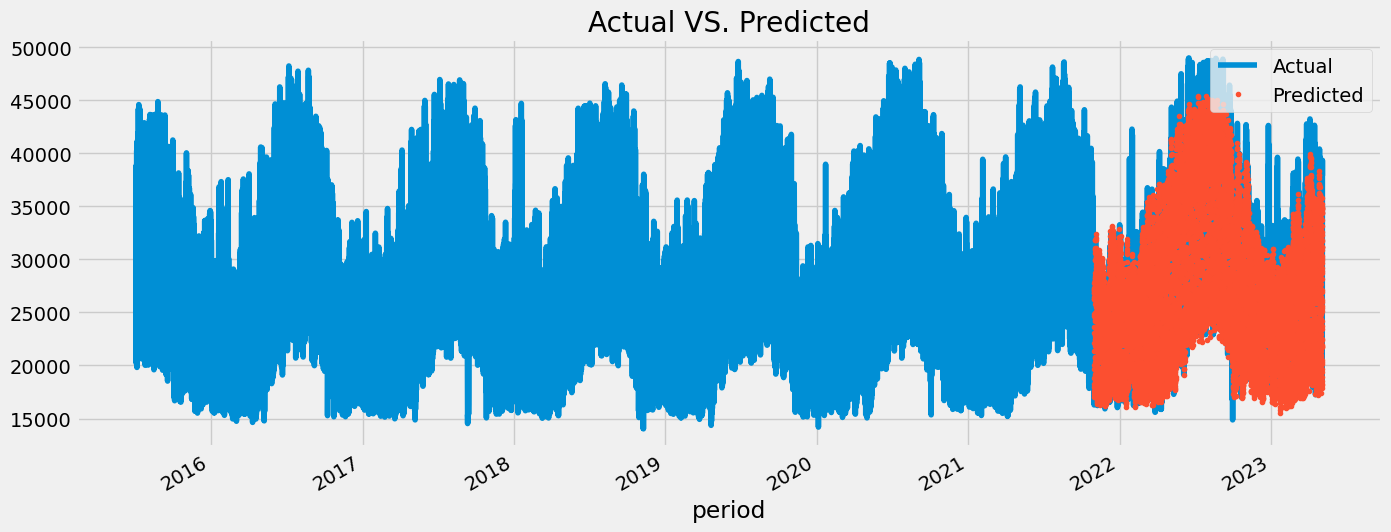

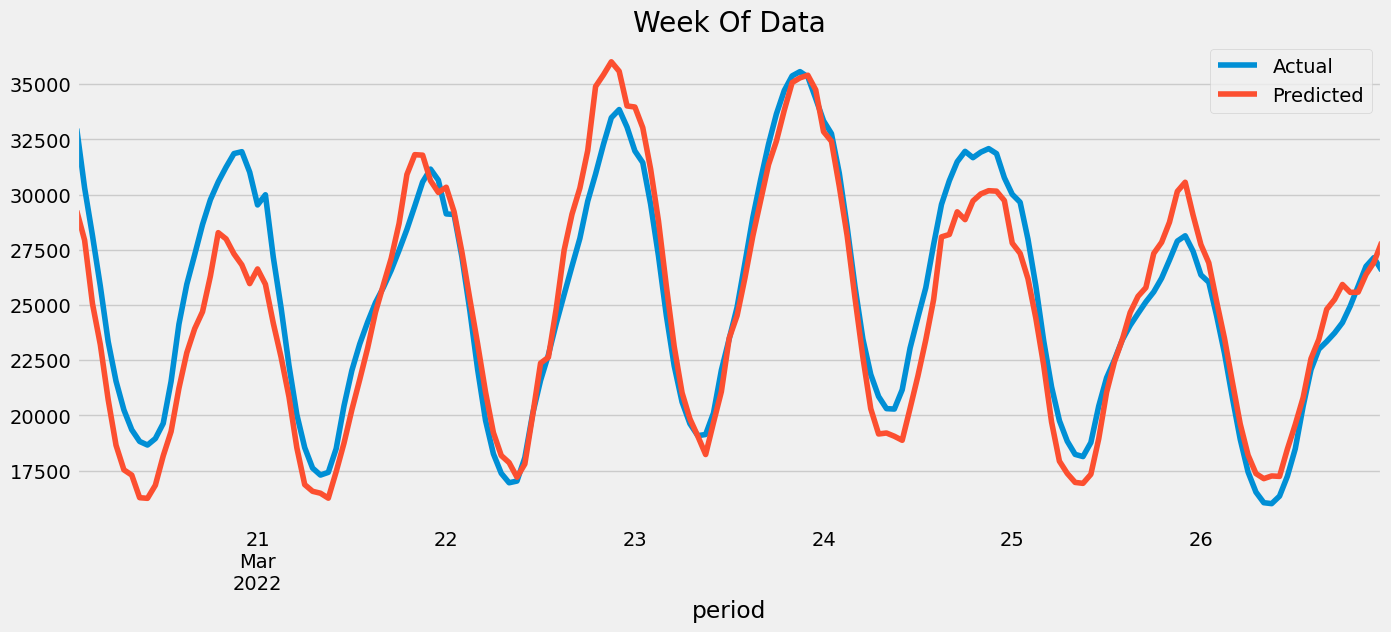

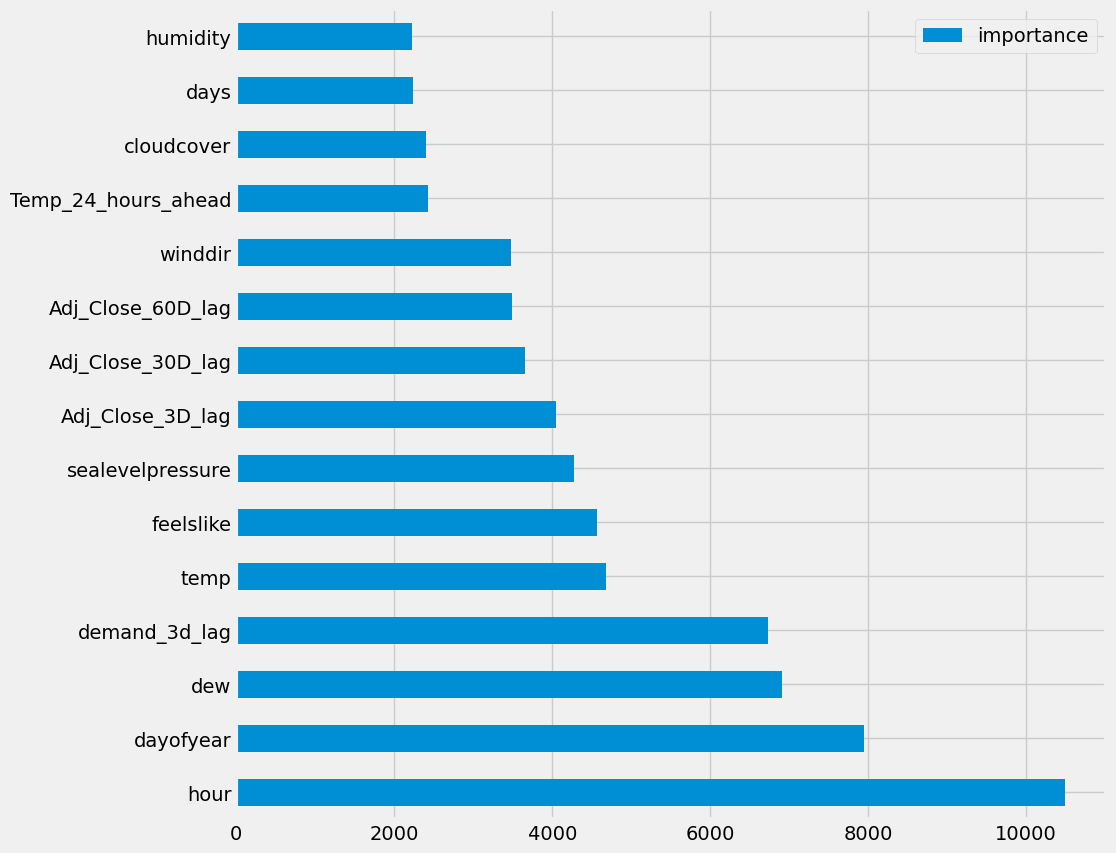

In [10]:
model_FL, FL_df = lgbm_train(FL, TX_params1, show_graph='yes')

## Save model to pickel file

In [ ]:
def create_pickle(model, filename, df, df_name):
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(model, f)
    df.to_parquet(f'{df_name}.parquet', engine='pyarrow')

In [ ]:
# dump_tx = create_pickle(model_TX, '../app/Data/TX/model_TX',Texas_df,'../app/Data/TX/texas_df')
# dump_ny = create_pickle(model_NY, '../app/Data/NY//model_NY',NY_df,'../app/Data/NY/NY_df')
# dump_fl = create_pickle(model_FL, '../app/Data/FL/model_FL',FL_df,'../app/Data/FL/FL_df')
# dump_ca = create_pickle(model_CA, '../app/Data/CA/model_CA',CA_df,'../app/Data/CA/CA_df')